In [1]:
import pandas as pd
import seaborn as sns
from fastai.structured import *
from fastai.column_data import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
np.set_printoptions(threshold=50, edgeitems=20)

import gc
gc.enable()

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
PATH = "data/bondora/"

# Load Data

In [3]:
df = pd.read_csv(f"{PATH}public_report.csv", low_memory=False)
df = df.drop_duplicates()

In [4]:
len(df)

11827

In [5]:
df.defaultdate = df.defaultdate.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.biddingstartedon = df.biddingstartedon.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.debtoccuredon = df.debtoccuredon.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.debtoccuredonforsecondary = df.debtoccuredonforsecondary.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.loandate = df.loandate.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.firstpaymentdate = df.firstpaymentdate.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.lastpaymenton = df.lastpaymenton.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.maturitydate_last = df.maturitydate_last.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.maturitydate_original = df.maturitydate_original.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.contractenddate = df.contractenddate.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.dateofbirth = df.dateofbirth.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.graceperiodstart = df.graceperiodstart.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.graceperiodend = df.graceperiodstart.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.listedonutc = df.listedonutc.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.loanapplicationstarteddate = df.loanapplicationstarteddate.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
#df.stageactivesince = df.stageactivesince.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.rescheduledon = df.rescheduledon.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))

In [6]:
df.reset_index(drop=True, inplace=True)

In [7]:
df.to_feather(f"{PATH}df")

In [8]:
df = pd.read_feather(f"{PATH}df")

# Data used in training and validation

The dataset "Current exluded" contains rows with status "Late" and "Repaid". It's meant to be used in a model which predicts the default probability of loans using data that was available when the loan was created. 

If you click on fields under "Current excluded", ignore fields under "Late excluded". When running "Late excluded" remember to go through fields at the end of this notebook under "Repaid excluded".

Checking for columns with no values

In [9]:
df.creditscoreeemini.unique()

array([nan])

In [10]:
df.creditscoreesequifaxrisk.unique()

array([nan])

In [11]:
df.creditscoreesmicrol.unique()

array([None, 'M'], dtype=object)

In [12]:
df.creditscorefiasiakastietoriskgrade.unique()

array(['RL1', 'RL2', 'RL4', 'RL3', None, 'RL5', '3', '4', '2', '5', 'RL0', '1', '6', '7'], dtype=object)

Columns to be dropped, because:
- column data may "reveal" status of row
- column is empty

In [13]:
to_be_dropped = [
    'debtoccuredon',
    'creditscoreeemini',
    'creditscoreesequifaxrisk',
    'creditscoreesmicrol',
    'activelatecategory', 
    'activeschedulefirstpaymentreached',
    'currentdebtdaysprimary',
    'currentdebtdayssecondary',
    'contractenddate',
    'debtoccuredonforsecondary', 
    'defaultdate',
    'ead1',
    'ead2',
    'el_v0',
    'el_v1',
    'el_v2',
    'expectedloss',
    'expectedreturn',
    'firstpaymentdate',
    'graceperiodend',
    'graceperiodstart',
    'interestandpenaltybalance',
    'interestandpenaltydebtservicingcost',
    'interestandpenaltypaymentsmade',
    'interestandpenaltywriteoffs',
    'interestrecovery',
    'lastpaymenton',
    'loancancelled',
    'loanid',
    'loannumber',
    'lossgivendefault',
    'listedonutc',
    'maturitydate_last',
    'modelversion',
    'nrofscheduledpayments',
    'nextpaymentnr',
    'nextpaymentdate',
    'plannedinterestpostdefault',
    'plannedinteresttilldate',
    'plannedprincipalpostdefault',
    'plannedprincipaltilldate',
    'principalbalance',
    'principaldebtservicingcost',
    'principaloverduebyschedule',
    'principalpaymentsmade',
    'principalrecovery',
    'principalwriteoffs',
    'probabilityofdefault',
    'rating',
    'rating_v0',
    'rating_v1',
    'rating_v2',
    'rescheduledon',
    'recoverystage',
    'restructured',
    'stageactivesince',
    'username',
    'worselatecategory',
]

In [14]:
df = df.drop(to_be_dropped, axis=1)

In [15]:
len(df.columns)

54

In [16]:
x = df.loc[df['status'] == "Current"].index
df = df.loc[~df.index.isin(x)]

In [17]:
len(df)

8496

In [18]:
status_d = {}
n = 0

for k in df.status.unique():
    status_d[k] = n
    n += 1

In [19]:
status_d

{'Repaid': 0, 'Late': 1}

In [20]:
df = df.replace({"status": status_d})

Drop rows with no monthlypayment data

In [21]:
x = df.monthlypayment.notnull()
x = np.where(x == True)[0]
df = df.loc[df.index.isin(x)]
len(df)

6934

In [22]:
set1 = set(df.columns)

In [23]:
add_datepart(df, "biddingstartedon", drop=False)
# add_datepart(df, "debtoccuredon", drop=False)
add_datepart(df, "loanapplicationstarteddate", drop=False)
add_datepart(df, "loandate", drop=False)
add_datepart(df, "dateofbirth", drop=False)

In [24]:
add_datepart_original = ['biddingstartedon', 'loanapplicationstarteddate', 'loandate', 'dateofbirth']

In [25]:
set2 = set(df.columns)

In [26]:
added = list(set2.difference(set1))

In [27]:
add = add_datepart_original+added

In [28]:
cat_vars = ['age',
            'applicationsignedhour',
            'applicationsignedweekday',
            'bidsapi',
            'city',
            'country',
            'county',
            'creditscorefiasiakastietoriskgrade',
            #'debtoccuredon',
            'education',
            'employmentdurationcurrentemployer',
            'employmentposition',
            'employmentstatus',
            'existingliabilities',
            'freecash',
            'gender',
            'homeownershiptype',
            'languagecode',
            'maritalstatus',
            'maturitydate_original',
            'monthlypaymentday',
            'newcreditcustomer',
            'noofpreviousloansbeforeloan',
            'nrofdependants',
            'occupationarea',
            'previousearlyrepaymentscountbeforeloan',
            'refinanceliabilities',
            'useofloan',
            'verificationtype',
            'workexperience',] + add

In [29]:
cont_vars = ['amount',
               'amountofpreviousloansbeforeloan',
               'appliedamount',
               'bidsmanual',
               'bidsportfoliomanager',
               'debttoincome',
               'incomefromchildsupport',
               'incomefromfamilyallowance',
               'incomefromleavepay',
               'incomefrompension',
               'incomefromprincipalemployer',
               'incomefromsocialwelfare',
               'incomeother',
               'incometotal',
               'interest',
               'liabilitiestotal',
               'loanduration',
               'monthlypayment',
               'previousearlyrepaymentsbeforeloan',
               'previousrepaymentsbeforeloan',]

In [30]:
len(cat_vars)

85

In [31]:
len(cont_vars)

20

In [32]:
df[df.isin([np.inf, -np.inf]).any(1)]

,age,amount,amountofpreviousloansbeforeloan,applicationsignedhour,applicationsignedweekday,appliedamount,biddingstartedon,bidsapi,bidsmanual,bidsportfoliomanager,...,dateofbirthDay,dateofbirthDayofweek,dateofbirthDayofyear,dateofbirthIs_month_end,dateofbirthIs_month_start,dateofbirthIs_quarter_end,dateofbirthIs_quarter_start,dateofbirthIs_year_end,dateofbirthIs_year_start,dateofbirthElapsed


In [33]:
for v in cont_vars:   
    df[v] = df[v].fillna(0).astype('float32')

In [34]:
for v in cat_vars: df[v] = df[v].astype('category').cat.as_ordered()

In [35]:
cat_sz = [(c, len(df[c].cat.categories)+1) for c in cat_vars]

In [36]:
len(list(df.columns))

106

In [37]:
df, y, nas, mapper = proc_df(df, 'status', do_scale=True)

In [38]:
trn_df, val_df, y_trn, y_val = train_test_split(df, y, test_size=0.2, random_state=42)

# Train MixedInput Model

In [92]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [93]:
md = ColumnarModelData.from_data_frames(PATH, trn_df = trn_df, val_df = val_df, 
                                         trn_y = y_trn.astype('int'), val_y = y_val.astype('int'), 
                                         cat_flds=cat_vars, bs=512, is_reg=False, is_multi=False, test_df=None)

In [94]:
class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont= n_emb, n_cont
        szs = [n_emb + n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range
        self.is_reg = is_reg
        self.is_multi = is_multi

    def forward(self, x_cat, x_cont):
        x = []
        for i,e in enumerate(self.embs):
            x.append(e(x_cat[:,i]))
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        x2 = self.bn(x_cont)
        x = torch.cat([x, x2], 1)
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        x = F.log_softmax(x)
        return x

In [95]:
m = MixedInputModel(emb_szs, n_cont = len(trn_df.columns)-len(cat_vars),
                   emb_drop = 0.05, out_sz = 2, szs = [500, 250, 250], drops = [0.1, 0.1, 0.1], 
                   y_range = None, use_bn = False, is_reg = False, is_multi = False)
bm = BasicModel(m.cuda(), 'binary_classifier')

In [96]:
class StructuredLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.nll_loss
# Instantiate learner
learn = StructuredLearner(md, bm)

In [97]:
def roc_auc(results, targets):
    return roc_auc_score(targets, results[:,1])

In [98]:
metrics =[accuracy]

In [46]:
lr = 1e-1
learn.fit(lr, 10, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                 
    0      0.606803   0.595729   0.722422  
    1      0.596351   0.58415    0.722422               
    2      0.588844   0.568206   0.722422                 
    3      0.58292    0.562757   0.722422                 
    4      0.577071   0.568106   0.723864                 
    5      0.572353   0.55598    0.723143                 
    6      0.568987   0.566594   0.723143                  
    7      0.561456   0.547754   0.738284                 
    8      0.553518   0.555347   0.736121                 
    9      0.543267   0.54831    0.739726                



[array([0.54831]), 0.7397260255064135]

In [99]:
lr = 1e-1
learn.fit(lr, 10, metrics=[roc_auc])

epoch      trn_loss   val_loss   roc_auc                  
    0      0.619723   0.586474   0.625634  
    1      0.595976   0.567781   0.658259                  
    2      0.583386   0.557945   0.67511                   
    3      0.573438   0.550585   0.682386                 
    4      0.567846   0.554108   0.691367                
    5      0.562028   0.54797    0.693723                 
    6      0.554333   0.564549   0.695567                 
    7      0.548196   0.569882   0.691414                 
    8      0.541521   0.546597   0.6975                   
    9      0.534042   0.54051    0.68669                  



[array([0.54051]), 0.6866898726541375]

# Analyze Predictions

Predictions by Model

In [47]:
c = 2 

def run_model(learn, dl):
    results = torch.zeros(1, c).cuda()
    learn.model.eval()
    it = iter(dl)
    _next = True
    while _next:
        try:
            x_cat, x_cont, y = next(it)
            probs = learn.model(V(x_cat), V(x_cont)).float().exp().data
            results = torch.cat((results, probs), dim=0)
        except StopIteration:
            _next = False
    results = results.cpu().numpy()
    return results[1:]

/home/kimmo/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


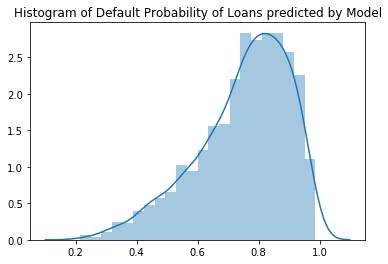

In [48]:
preds = run_model(learn, md.val_dl)
preds = preds[:,1]
plt.title('Histogram of Default Probability of Loans predicted by Model')
sns.distplot(preds)

Bondora's probabilityofdefault

In [49]:
df = pd.read_feather(f"{PATH}df")

In [51]:
index = val_df.index
x = df.probabilityofdefault.notnull()
x = np.where(x == True)[0]
probs_df = df.loc[(df.index.isin(x)) & (df.index.isin(index))]
probs = probs_df['probabilityofdefault'].values
probs_df = probs_df.replace({"status": status_d}) 
probs_y = probs_df.status.values

In [52]:
probs

array([0.29365, 0.07718, 0.17087, 0.14575, 0.13677, 0.15833, 0.12818, 0.07176, 0.06504, 0.07906, 0.10482,
       0.13239, 0.03809, 0.17658, 0.43319, 0.06667, 0.03908, 0.08699, 0.16158, 0.11221, ..., 0.38456,
       0.31463, 0.34569, 0.32053, 0.43792, 0.33461, 0.38023, 0.03872, 0.28653, 0.4117 , 0.41066, 0.28506,
       0.39185, 0.40287, 0.36175, 0.22843, 0.39729, 0.44444, 0.4377 , 0.34595])

In [53]:
status_d

{'Repaid': 0, 'Late': 1}

/home/kimmo/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


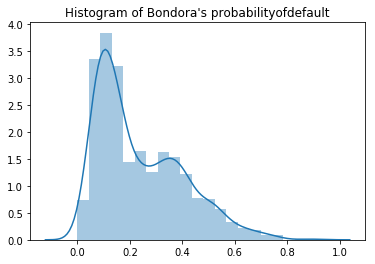

In [54]:
plt.title('''Histogram of Bondora's probabilityofdefault''')
sns.distplot(probs)

#### F1 score

Predictions by Model

In [55]:
# F1 score conveys the balance between the precision and the recall

preds = run_model(learn, md.val_dl)
preds = preds[:,1]
preds = np.rint(preds)
y = md.val_dl.dataset.y
sklearn.metrics.f1_score(y, preds, labels=None, pos_label=1, average="binary", sample_weight=None)

0.8417360806663745

Bondora's probabilityofdefault

In [56]:
probs = np.rint(probs)
sklearn.metrics.f1_score(probs_y, probs, labels=None, pos_label=1, average="binary", sample_weight=None)

0.17857142857142858

#### Confusion Matrix

In [57]:
preds = run_model(learn, md.val_dl)
preds = (preds>0.5).astype(int)
preds = preds[:,1]
y = md.val_dl.dataset.y

In [58]:
y_actu = y
y_pred = preds.astype('int')

#df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [59]:
df_confusion

Predicted,0,1,All
Actual,,,
0,66,319,385
1,42,960,1002
All,108,1279,1387


In [60]:
# Actual default rate:

df_confusion.iloc[1]['All'], df_confusion.iloc[2]['All'], np.round(df_confusion.iloc[1][1]/df_confusion.iloc[2]['All'], 2)

(1002, 1387, 0.69)

#### Precision and Recall

In [61]:
# default precision:

df_confusion.iloc[1][1], df_confusion.iloc[2][1], np.round(df_confusion.iloc[1][1]/df_confusion.iloc[2][1], 2)

(960, 1279, 0.75)

In [62]:
# default recall

df_confusion.iloc[1][1], df_confusion.iloc[1]['All'], np.round(df_confusion.iloc[1][1]/df_confusion.iloc[1]['All'], 2)

(960, 1002, 0.96)

In [63]:
# non-default precision:

df_confusion.iloc[0][0], df_confusion.iloc[2][0], np.round(df_confusion.iloc[0][0]/df_confusion.iloc[2][0], 2)

(66, 108, 0.61)

In [64]:
# non-default recall:

df_confusion.iloc[0][0], df_confusion.iloc[0]['All'], np.round(df_confusion.iloc[0][0]/df_confusion.iloc[0]['All'], 2)

(66, 385, 0.17)

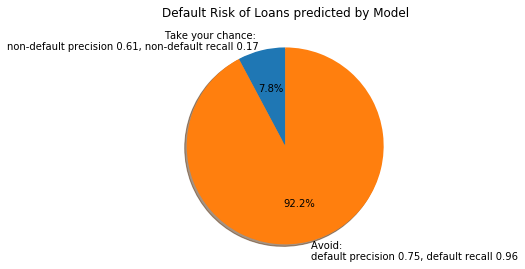

In [65]:
other = df_confusion.iloc[2]['All']-df_confusion.iloc[2][1]
high_risk = df_confusion.iloc[2][1]

recall = np.round(df_confusion.iloc[1][1]/df_confusion.iloc[1]['All'], 2)
precision = np.round(df_confusion.iloc[1][1]/df_confusion.iloc[2][1], 2)

non_default_precision = np.round(df_confusion.iloc[0][0]/df_confusion.iloc[2][0], 2)
non_default_recall = np.round(df_confusion.iloc[0][0]/df_confusion.iloc[0]['All'], 2)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [f'Take your chance: \nnon-default precision {non_default_precision}, non-default recall {non_default_recall}', 
          f'Avoid: \ndefault precision {precision}, default recall {recall}']

sizes = other, high_risk  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Default Risk of Loans predicted by Model\n')
plt.show()

#### Precision / Recall Curve

Predictions by Model

In [66]:
y_scores = run_model(learn, md.val_dl)
y_scores = y_scores[:,1]

y_true = y

In [67]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

In [68]:
average_precision = average_precision_score(y_true, y_scores)
average_precision

0.8385342032233524

Text(0.5,1,'2-class Precision-Recall curve: AP=0.84')

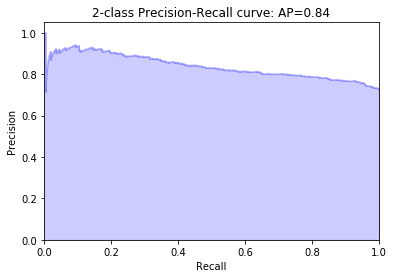

In [69]:
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

Bondora's probabilityofdefault

In [70]:
average_precision = average_precision_score(probs_y, probs)
average_precision

0.7358401473990157

#### ROC curve

In [72]:
# matplotlib.rcParams['figure.figsize'] = (4,4)

Predicted by Model

In [73]:
status_d

{'Repaid': 0, 'Late': 1}

In [74]:
y_true = []
for i in y:
    if i == 0:
        y_true.append([1,0])
    if i == 1:
        y_true.append([0,1])

In [75]:
preds = run_model(learn, md.val_dl)

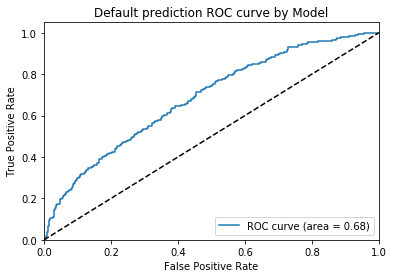

In [76]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

n_classes = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.asarray(y_true)[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve 
plt.figure()
plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Default prediction ROC curve by Model')
plt.legend(loc="lower right")
plt.show()

Bondora's probabilityofdefault

In [77]:
y_true = []
for i in probs_y:
    if i == 0:
        y_true.append([1,0])
    else:
        y_true.append([0,1])

In [78]:
probs1 = np.array([[1-i, i] for i in probs])

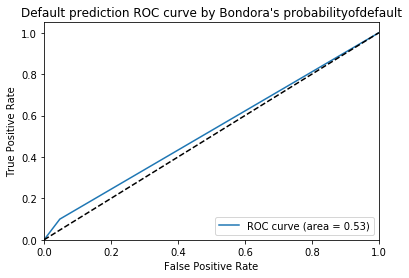

In [79]:
n_classes = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.asarray(y_true)[:, i], probs1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve 
plt.figure()
plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('''Default prediction ROC curve by Bondora's probabilityofdefault''')
plt.legend(loc="lower right")
plt.show()

#### Loan Sums (euros) by predicted likelihood to default

In [81]:
preds = run_model(learn, md.val_dl)
preds = (preds>=0.5).astype(int)
preds = preds[:,1]

In [82]:
df = pd.read_feather(f"{PATH}df")

In [83]:
amount_df = pd.DataFrame({'Risk Category':preds,'Amount':df.loc[val_df.index].amount.values}).groupby("Risk Category").sum()

In [84]:
amount_dict = amount_df.to_dict()
amount_dict = amount_dict['Amount']

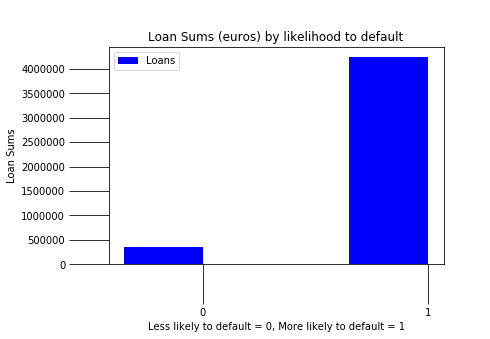

In [85]:
amount = amount_dict.values()
ind = np.arange(len(amount_dict)) # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, amount, width, 
                color='Blue', label='Loans')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loan Sums')
ax.set_xlabel('Less likely to default = 0, More likely to default = 1')
ax.set_title('Loan Sums (euros) by likelihood to default')

ax.set_xticks(ind)
ax.set_xticklabels(amount_dict.keys())
ax.tick_params(length=40)

ax.legend()

plt.show()

#### Interest by predicted likelihood to default

In [86]:
interest_df = pd.DataFrame({'Risk Category':preds,'Interest':df.loc[val_df.index].interest.values}).groupby("Risk Category").mean()

In [87]:
interest_dict = interest_df.to_dict()
interest_dict = interest_dict['Interest']

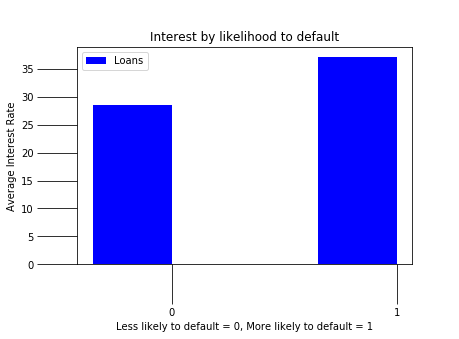

In [88]:
interest = interest_dict.values()
ind = np.arange(len(interest_dict)) # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, interest, width, 
                color='Blue', label='Loans')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Interest Rate')
ax.set_xlabel('Less likely to default = 0, More likely to default = 1')
ax.set_title('Interest by likelihood to default')
ax.legend()

ax.set_xticks(ind)
ax.set_xticklabels(interest_dict.keys())
ax.tick_params(length=40)


plt.show()

# Train LGBM Model

In [195]:
for v in cont_vars:   
    df[v] = df[v].fillna(0).astype('float32')

In [196]:
df, y, nas, mapper = proc_df(df, 'status', do_scale=True)

In [197]:
for v in cat_vars: df[v] = df[v].astype('category').cat.as_ordered()

In [154]:
# https://www.kaggle.com/mlisovyi/beware-of-categorical-features-in-lgbm

In [198]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.20, random_state=42, stratify=y)

In [200]:
fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }

In [201]:
import lightgbm as lgb
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 1000 define only the absolute maximum
clf = lgb.LGBMClassifier(num_leaves= 15, max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='None', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1)

In [202]:
#force larger number of max trees and smaller learning rate
clf.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[6]	valid's auc: 0.615998


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        learning_rate=0.1, max_depth=-1, metric='None',
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=4, num_leaves=15, objective=None,
        random_state=314, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

#### Analyze feauture importance

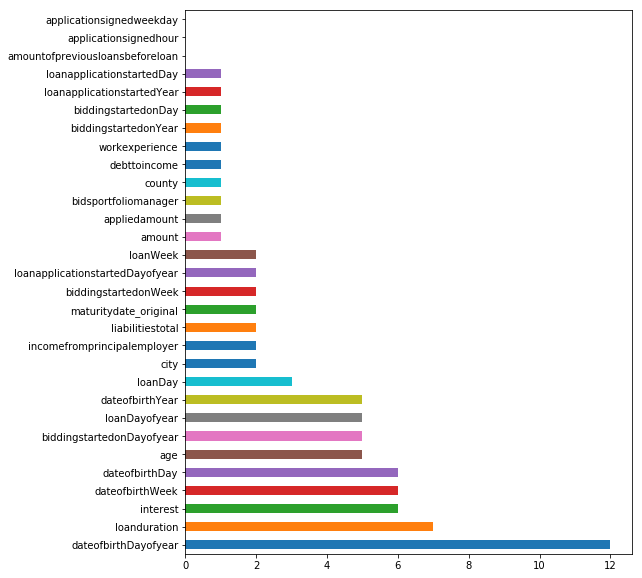

In [203]:
feat_imp = pd.Series(clf.feature_importances_, index=df.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [204]:
class LGBMClassifier_GainFE(lgb.LGBMClassifier):
    @property
    def feature_importances_(self):
        if self._n_features is None:
            raise LGBMNotFittedError('No feature_importances found. Need to call fit beforehand.')
        return self.booster_.feature_importance(importance_type='gain')

In [205]:
clf2 = LGBMClassifier_GainFE(num_leaves= 15, max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='None', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1)


In [206]:
clf2.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[6]	valid's auc: 0.615998


LGBMClassifier_GainFE(boosting_type='gbdt', class_weight=None,
           colsample_bytree=0.9, learning_rate=0.1, max_depth=-1,
           metric='None', min_child_samples=20, min_child_weight=0.001,
           min_split_gain=0.0, n_estimators=1000, n_jobs=4, num_leaves=15,
           objective=None, random_state=314, reg_alpha=0.0, reg_lambda=0.0,
           silent=True, subsample=0.9, subsample_for_bin=200000,
           subsample_freq=0)

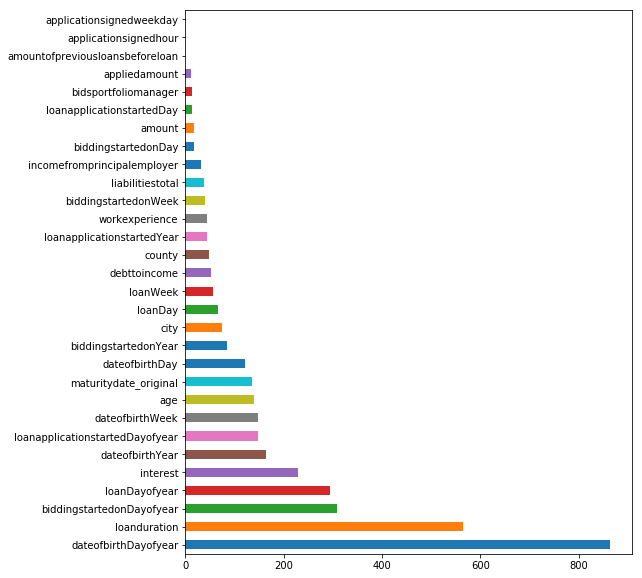

In [207]:
feat_imp = pd.Series(clf2.feature_importances_, index=df.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [208]:
import shap
shap.initjs()

In [209]:
shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)

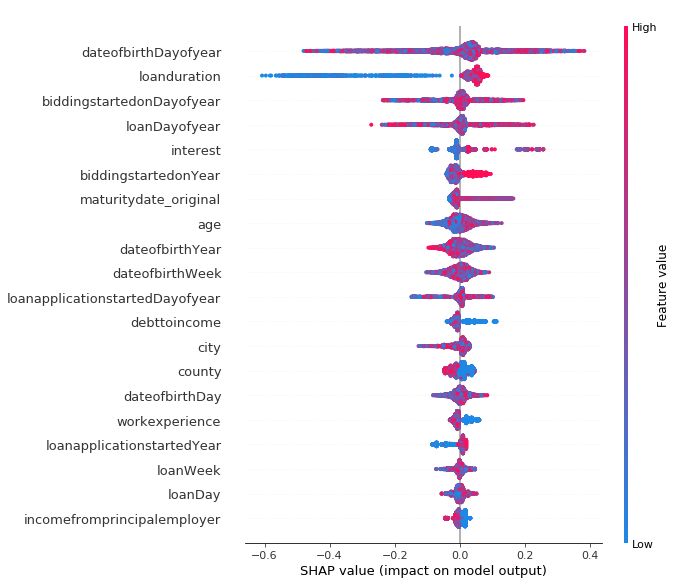

In [210]:
shap.summary_plot(shap_values, X_train)

In [144]:
#https://github.com/slundberg/shap